# Introduction  
This notebook was used to test the changes made to the Open3D source code, on various meshes, available in the data folder

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import pyvista as pv

In [ ]:
# point_cloud = np.loadtxt('data/bunny_fine.txt', delimiter=",", skiprows=1)           # without normals
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(point_cloud[:,:3])

## Set lambda and cos_alpha_tresh 

In [11]:
# true normals:
#point_cloud_normals = np.loadtxt('sphere_normals.txt', delimiter=",", skiprows=1)           # sphere with normals
# use lamb = 0, cosa = 1 for default values
lamb = 10
cosa = 0.5

point_cloud_normals = np.loadtxt('data/bunny_norm_new.txt', delimiter=",", skiprows=1)           # bunny with normals

pcd_norm = o3d.geometry.PointCloud()
pcd_norm.points = o3d.utility.Vector3dVector(point_cloud_normals[:,3:6])
pcd_norm.normals = o3d.utility.Vector3dVector(point_cloud_normals[:,:3])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud_normals[:,3:6])

pcd.estimate_normals()
pcd.orient_normals_consistent_tangent_plane(9, lamb, cosa) #knn, lambda, cosalpha            # 100 for sphere, 11 for bunny


# est_normals = np.asarray(pcd.normals)
# est_normals = - est_normals

# pcd.normals = o3d.utility.Vector3dVector(est_normals)

In [12]:
# Animation callback function. it needs to contain as a minimum the visualizer reference
def rotate_around(vis):
    # We create a 3D rotation matrix from x,y,z rotations, the rotations need to be given in radians
    R = mesh.get_rotation_matrix_from_xyz((0,0,  np.deg2rad(1)))
    # The rotation matrix is applied to the specified object - in our case the mesh. We can also specify the rotation pivot center
    mesh.rotate(R, center=np.mean(mesh.vertices,0))

    # We create a 3D rotation matrix for the sphere as well in the opposite direction
    R_sphere = mesh.get_rotation_matrix_from_xyz((0, np.deg2rad(-4), 0))
    # Apply it
    sphere_mesh.rotate(R_sphere, center=(0, 0, 0))
    # For the changes to be seen we need to update both the geometry that has been changed and to update the whole renderer connected to the visualizer
    vis.update_geometry(mesh)
    vis.update_geometry(sphere_mesh)
    vis.update_renderer()



#print(o3d._version_)

# Load mesh, together with setting the flag for post-processing to True, so the texture and material will be loaded
mesh_path = "bunny_norm_new.txt"   #'mesh/angelStatue_lp.obj'
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, width=0, scale=1.1, linear_fit=False)[0]
mesh.paint_uniform_color([0.9, 0.5, 0.2])
mesh.compute_vertex_normals()

print(mesh)
print('Vertices:')
print(np.asarray(mesh.vertices))
print('Triangles:')
print(np.asarray(mesh.triangles))


# We can extract information from the mesh like faces, UVs and texture
mesh_faces = mesh.triangles
mesh_uvs = mesh.triangle_uvs
texture = mesh.textures



# We create a visualizer object that will contain references to the created window, the 3D objects and will listen to callbacks for key presses, animations, etc.
vis = o3d.visualization.Visualizer()
# New window, where we can set the name, the width and height, as well as the position on the screen
vis.create_window(window_name='Title', width=800, height=600)

# We call add_geometry to add a mesh or point cloud to the visualizer
vis.add_geometry(mesh)

# We can easily create primitives like cubes, sphere, cylinders, etc. In our case we create a sphere and specify its radius
sphere_mesh = o3d.geometry.TriangleMesh.create_sphere(radius=0.05)

# We can compute either vertex or face normals
sphere_mesh.compute_vertex_normals()
# Add the sphere to the visualizer
vis.add_geometry(sphere_mesh)
# Translate it from the center
sphere_mesh.translate((1, 0, 0))

#Initial rotation
R = mesh.get_rotation_matrix_from_xyz((0, 0, 0)) #x = -np.deg2rad(60)
mesh.rotate(R, center=(0, 0, 20))
vis.update_geometry(mesh)
vis.update_geometry(sphere_mesh)
vis.update_renderer()

# We can register callback animation functions that will be run on every update cycle
vis.register_animation_callback(rotate_around)
# We run the visualizater
vis.run()
# Once the visualizer is closed destroy the window and clean up
vis.destroy_window()

TriangleMesh with 10990 points and 21976 triangles.
Vertices:
[[-4.55733871e+00  8.90485764e+00  9.30595398e-03]
 [-1.60502434e+01 -4.40982628e+00  9.30595398e-03]
 [ 1.33663101e+01 -1.71337128e-02  9.30595398e-03]
 ...
 [-8.96261215e-01  5.33921432e+00  4.94012680e+01]
 [-8.96261215e-01  6.23062515e+00  4.95645905e+01]
 [-4.85038757e-03  7.12203598e+00  4.95714302e+01]]
Triangles:
[[ 5339  5337  5707]
 [ 5353  5351  5714]
 [ 5561  5714  5707]
 ...
 [10737 10739 10836]
 [10836 10835 10737]
 [10839 10708 10686]]


average error 6.839111635098066
max error 171.06495041007494
min error 0.0
error > 90: 10


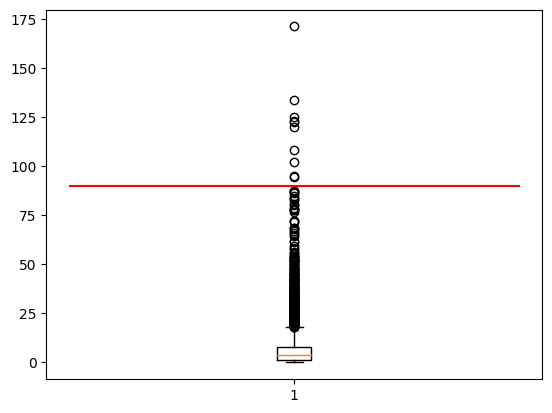

In [15]:
error_angle = []

for i in range(point_cloud_normals.shape[0]):
    scalar_prod = 0.0
    vec1 = 0.0
    vec2 = 0.0
    for k in range(3):
        scalar_prod += pcd.normals[i][k] * pcd_norm.normals[i][k]
    vec1 = np.sqrt(np.sum(pcd.normals[i]**2))           # estimated
    vec2 = np.sqrt(np.sum(pcd_norm.normals[i]**2))      # true
    alpha = np.arccos(scalar_prod / (vec1 * vec2)) / 3.14 * 180
    
    error_angle.append(alpha)

norm_error = np.sum(error_angle) / point_cloud_normals.shape[0]
print("average error", norm_error)
print("max error", np.max(error_angle))
print("min error", np.min(error_angle))

plt.boxplot(error_angle)
plt.hlines(90,0,2, colors='r')

# with log
# plt.figure()
# plt.boxplot(np.log(error_angle))
# plt.hlines(np.log(90),0,2, colors='r')

print("error > 90:", np.count_nonzero(np.asarray(error_angle) > 90))

In [ ]:
len(pcd.points)

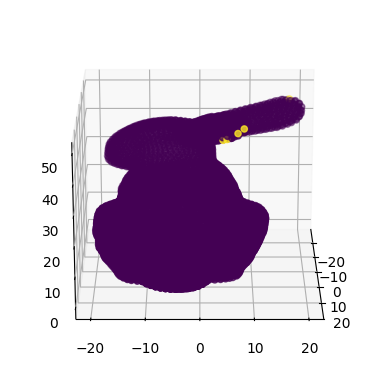

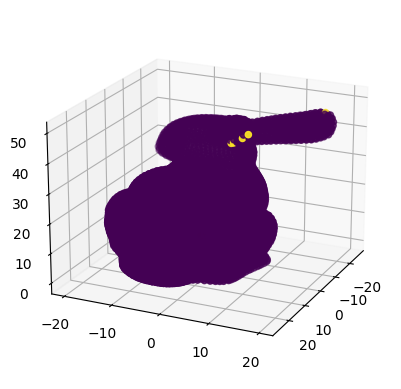

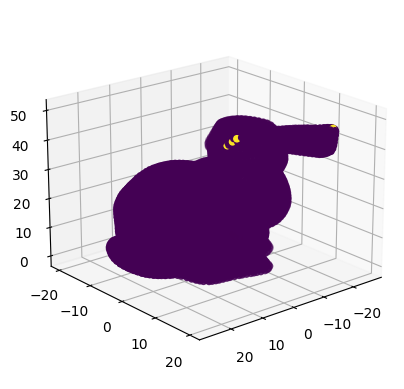

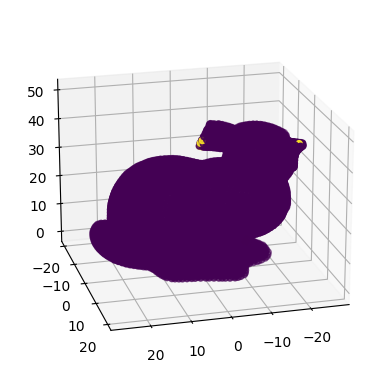

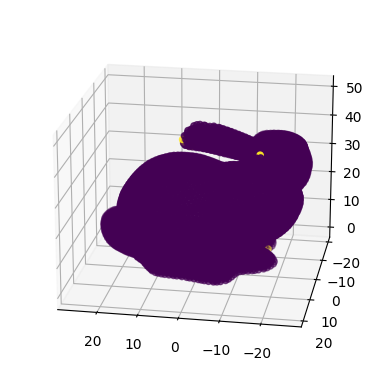

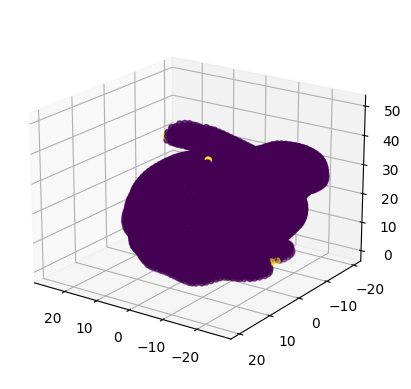

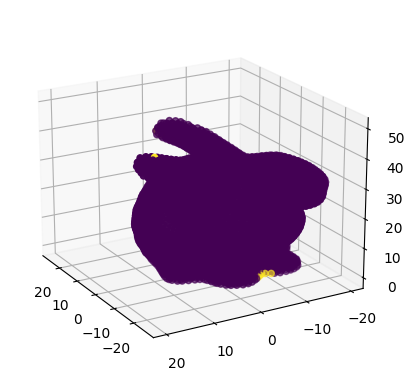

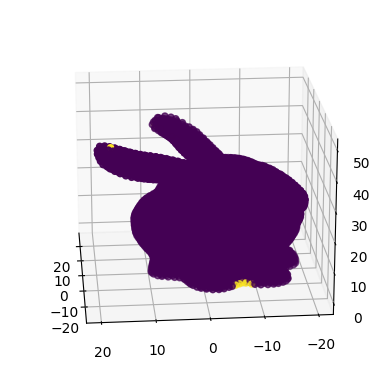

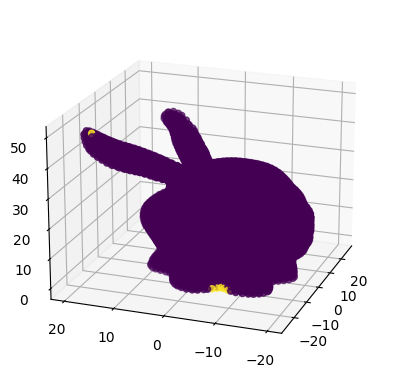

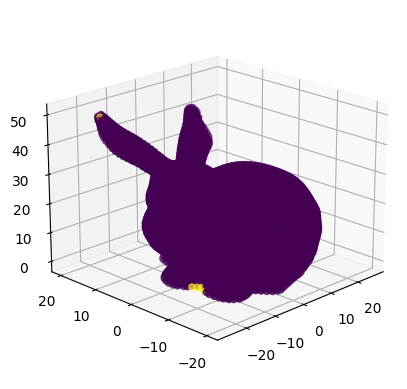

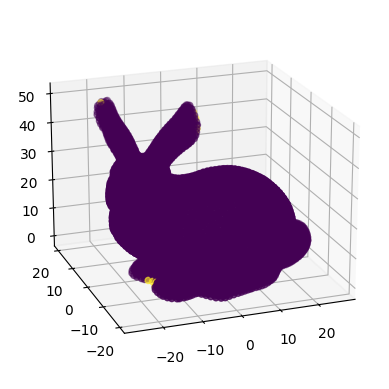

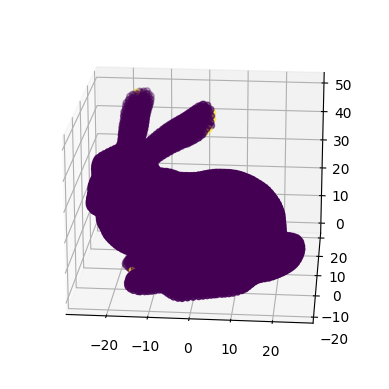

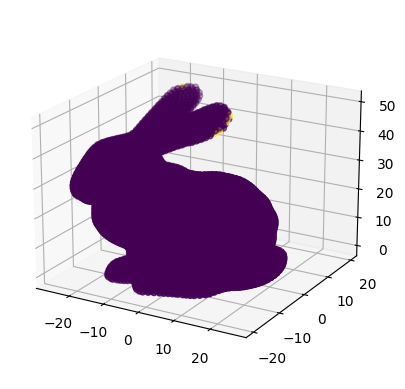

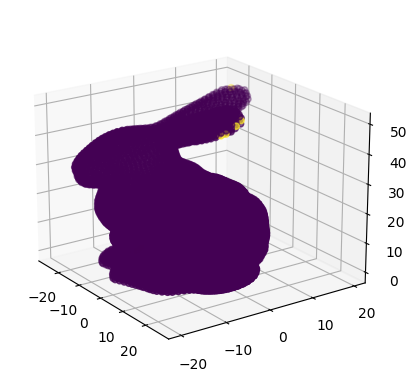

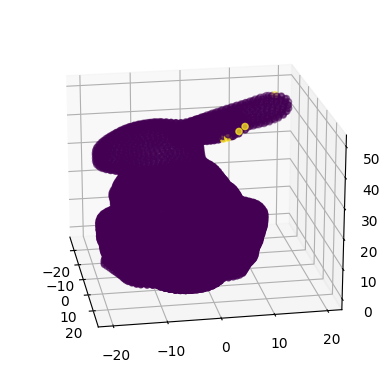

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

idx = np.where(np.asarray(error_angle) > 90)
colors = np.zeros(len(error_angle))
colors[idx] = 1.0
# maxm = np.argmax(np.asarray(pcd.points)[:, 2])

a = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350]

fig_list = []

for i in a:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(np.asarray(pcd.points)[:, 0], np.asarray(pcd.points)[:, 1], np.asarray(pcd.points)[:, 2], c=colors)
    ax.view_init(elev=20, azim=i)

    # Save plot as image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(fig.canvas.get_width_height()[::-1] + (3,))
    fig_list.append(Image.fromarray(image))

# Save animation as .gif
# fig_list[0].save('output/animazione_l0_c0.1.gif', format='GIF', append_images=fig_list[1:], save_all=True, duration=200, loop=0)


In [17]:
# 3D mesh using O3D
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, width=0, scale=1.1, linear_fit=False)[0]
poisson_mesh.paint_uniform_color(np.array([[0.5],[0.5],[0.5]]))

poisson_mesh.compute_vertex_normals()
print(np.asarray(poisson_mesh.triangle_normals))
o3d.visualization.draw_geometries([poisson_mesh])

[[-0.27725611 -0.73273179 -0.62147661]
 [-0.19928344 -0.75266273 -0.62752285]
 [-0.19789636 -0.74754732 -0.63404261]
 ...
 [ 0.87785154 -0.38841317  0.28019973]
 [ 0.90336089  0.39995806 -0.15483103]
 [ 0.66709673  0.7415966   0.07082682]]
